In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'cat-and-dog:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F23777%2F30378%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240610%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240610T222404Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dae47529464709d65a3b4003d731dc8e120fe56b64cf9e0298c514ad26607bc290931e9f8e72abcc36a79c9ff3ab79fb60b7087a35133ed25f3ae1a004c0fa249e210e44ec2a1728cf93623cdaac87195801769a541017405af503a82f84b65d8c171117f7b5d88726e9954af77eef3d0fc881dc11022100146ca25ead59b7a9bb046cbf8b8ab3f3ba5d48f0153cdc7cb1b75785f4acc26ebdcfe69e50dc83164afb373e6c62d7898c6842efd69f796ffc6e271001c1074c091f728a3e2b056fe8585505e75bf0dee912c01a15402a0c2bb4728d10c1f9f9405bb1d7a2c750d62c5b1e4529d0c1aa226bad13bfe286b8470b172ba35c19f1d2f7fad26f7a4ae5a'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 228487605 bytes downloaded
Downloaded and uncompressed: cat-and-dog
Data source import complete.


###  Importing Libraries

In [ ]:
# For data manipulation
import numpy as np
import pandas as pd

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Ingore the warnings
import warnings
warnings.filterwarnings('ignore')

# DL Libraries
import tensorflow
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.utils import image_dataset_from_directory

# Other libraries
import os
import random


###  Loading Image Dataset from Directory

In [ ]:
# Load the image dataset from the directory using utils
# ds = image_dataset_from_directory('E:\DataScience Codanics\Kaggle\LAPTOP Items classification\PC Part Classification\Data')

train_ds = keras.utils.image_dataset_from_directory(
    directory = '/kaggle/input/cat-and-dog/test_set/test_set',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(256, 256),
)

val_ds = keras.utils.image_dataset_from_directory(
    directory = '/kaggle/input/cat-and-dog/training_set/training_set',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(256, 256),
)


Found 2023 files belonging to 2 classes.
Found 8005 files belonging to 2 classes.


###  Visualize the images

In [ ]:
# Creating a function to visualize the images

def visualize_images(path, num_images=5):

    # Get a list of image filenames
    image_filenames = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

    if not image_filenames:
        raise ValueError("No images found in the specified path")

    # Select random images
    selected_images = random.sample(image_filenames, min(num_images, len(image_filenames)))

    # Create a figure and axes
    fig, axes = plt.subplots(1, num_images, figsize=(20, 4), facecolor='white')

    # Display each image
    for i, image_filename in enumerate(selected_images):
        # Load image
        image_path = os.path.join(path, image_filename)
        image = plt.imread(image_path)

        # Display image
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(image_filename)  # Set image filename as title

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

In [ ]:
# Extrating the class labels
classes = train_ds.class_names

CATS


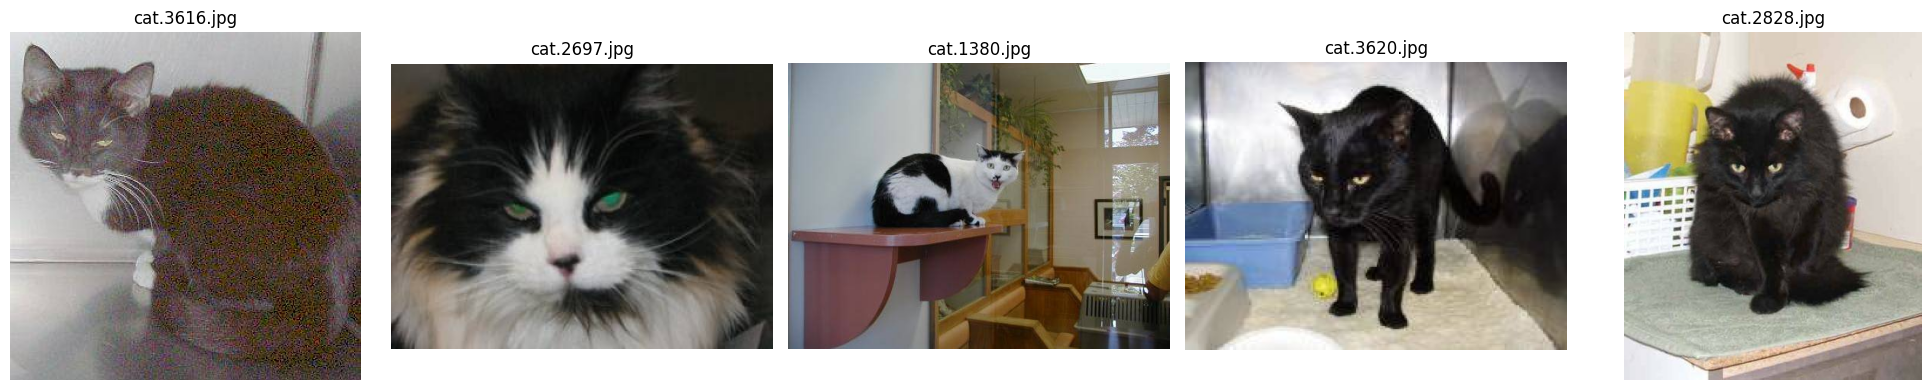

DOGS


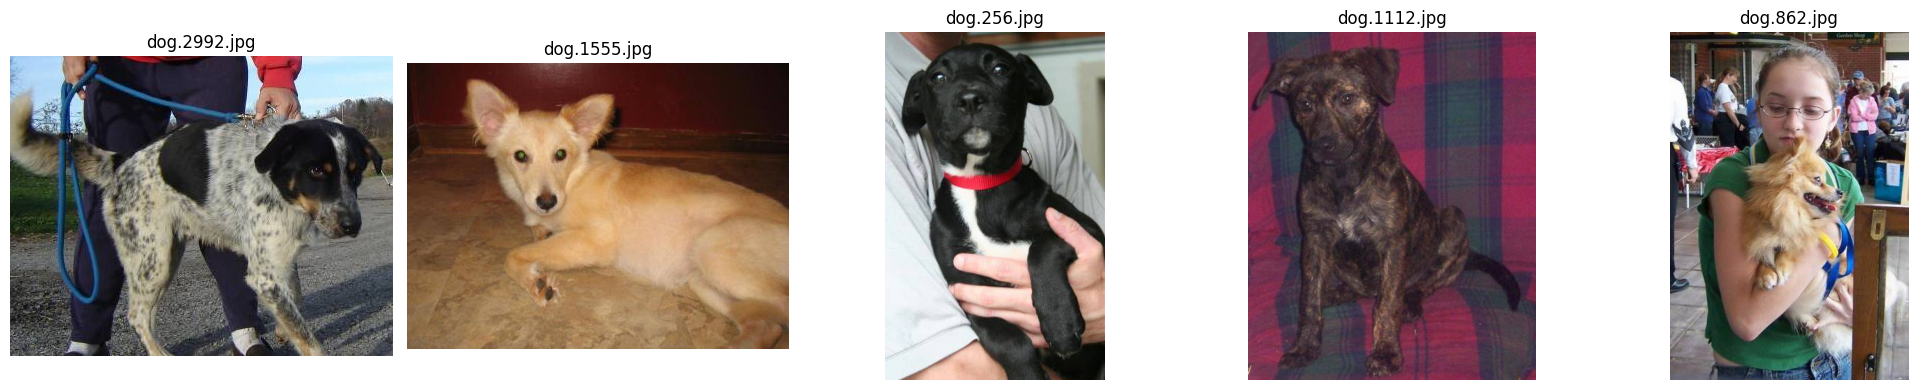

In [ ]:
# Iterating through each class to plot its images
for label in classes:

    # Specify the path containing the images to visualize
    path_to_visualize = f"/kaggle/input/cat-and-dog/training_set/training_set/{label}"

    # Visualize 5 random images
    print(label.upper())
    visualize_images(path_to_visualize, num_images=5)

### Model Building

In [ ]:
model = Sequential()

model.add(Conv2D(64, kernel_size=(3,3),activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(128, kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))


model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 128)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 492032)            0         
                                                                 
 dense (Dense)               (None, 128)               6

### **4.2 Model Compilation**

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### **4.3 Model Training**

In [ ]:
# Train the model

history = model.fit(train_ds, batch_size=32, epochs=10, validation_data=val_ds, verbose=1)

Epoch 1/10
64/64 [==============================] - 1274s 20s/step - loss: 57.9574 - accuracy: 0.5017 - val_loss: 0.6940 - val_accuracy: 0.5068
Epoch 2/10
64/64 [==============================] - 1282s 20s/step - loss: 0.6369 - accuracy: 0.6016 - val_loss: 0.7230 - val_accuracy: 0.5092
Epoch 3/10
64/64 [==============================] - 1234s 19s/step - loss: 0.4375 - accuracy: 0.7726 - val_loss: 0.8949 - val_accuracy: 0.5364
Epoch 4/10
64/64 [==============================] - 1268s 20s/step - loss: 0.3535 - accuracy: 0.8389 - val_loss: 1.5710 - val_accuracy: 0.5513
Epoch 5/10
64/64 [==============================] - 1221s 19s/step - loss: 0.2796 - accuracy: 0.8858 - val_loss: 1.5705 - val_accuracy: 0.5360
Epoch 6/10
64/64 [==============================] - 1267s 20s/step - loss: 0.2757 - accuracy: 0.8883 - val_loss: 2.8645 - val_accuracy: 0.5609
Epoch 7/10
64/64 [==============================] - 1218s 19s/step - loss: 0.1674 - accuracy: 0.9382 - val_loss: 2.1581 - val_accuracy: 0.558